In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
UAW_staff_by_year = [pd.read_csv(f"documents/UAW LM2s/{year}_staff.csv") for year in range(2005,2024)]
UAW_officers_by_year = [pd.read_csv(f"documents/UAW LM2s/{year}_officers.csv") for year in range(2005,2024)]
Teamsters_staff_by_year = [pd.read_csv(f"documents/Teamsters LM2s/{year}_staff.csv") for year in range(2005,2024)]
Teamsters_officers_by_year = [pd.read_csv(f"documents/Teamsters LM2s/{year}_officers.csv") for year in range(2005,2024)]

In [49]:
for i in range(19):
    UAW_staff_by_year[i]['Year'] = 2005 + i
    UAW_officers_by_year[i]['Year'] = 2005 + i
    Teamsters_staff_by_year[i]['Year'] = 2005 + i
    Teamsters_officers_by_year[i]['Year'] = 2005 + i

In [55]:
UAW_staff = pd.concat(UAW_staff_by_year).reset_index()
UAW_officers = pd.concat(UAW_officers_by_year).reset_index()
Teamsters_staff = pd.concat(Teamsters_staff_by_year).reset_index()
Teamsters_officers = pd.concat(Teamsters_officers_by_year).reset_index()

In [56]:
UAW_staff['Name'] = UAW_staff['First Name'] + ' ' + UAW_staff['Last Name']
UAW_officers['Name'] = UAW_officers['First Name'] + ' ' + UAW_officers['Last Name']
Teamsters_staff['Name'] = Teamsters_staff['First Name'] + ' ' + Teamsters_staff['Last Name']
Teamsters_officers['Name'] = Teamsters_officers['First Name'] + ' ' + Teamsters_officers['Last Name']

In [59]:
# Many of the titles annoying have spaces or incosistent capitalization.
# This cell removes all non-alpha characters and converts to uppercase.
f = lambda x: ("".join([a for a in str(x) if a.isalpha()])).upper()
UAW_staff['Title'] = UAW_staff['Title'].apply(f)
UAW_officers['Title'] = UAW_officers['Title'].apply(f)
Teamsters_staff['Title'] = Teamsters_staff['Title'].apply(f)
Teamsters_officers['Title'] = Teamsters_officers['Title'].apply(f)

In [84]:
def compute_retention(df):
    retention = pd.DataFrame({'Year':df['Year'].unique()}).set_index('Year')
    for i, year in enumerate(retention.index):
        current_staff = set(df[df['Year'] == year]['Name'])
        retention.loc[year, 'Total'] = len(current_staff)
        if i > 0:
            past_staff = set(df[df['Year'] == year - 1]['Name'])
            retention.loc[year, 'Retained'] = len(past_staff.intersection(current_staff))
            retention.loc[year, 'Turnover'] = -len(past_staff.difference(current_staff))
    retention['New'] = retention['Total'] - retention['Retained']
    return retention

UAW_staff_retention = compute_retention(UAW_staff)
UAW_officers_retention = compute_retention(UAW_officers)
Teamsters_staff_retention = compute_retention(Teamsters_staff)
Teamsters_officers_retention = compute_retention(Teamsters_officers)

# Charts

In [191]:
def plot_retentions(df, title):
    df = df.iloc[1:]
    fig, ax = plt.subplots(figsize = (8,3))
    plt.stackplot(df.index, 
                  df['Turnover'],
                  colors = 'r',
                  labels = ['Turnover'],
                 alpha = 0.5)
    plt.stackplot(df.index, 
                  df[['Retained', 'New']].transpose().values,
                  colors = ['tab:blue', 'g'],
                  labels = ['Retained', 'New'],
                 alpha = 0.5)

    plt.plot(df.index, df[['Turnover', 'Retained', 'Total']].values,
            color = 'black',
            marker = '.',
            linewidth = 1,
            )
    plt.plot(df.index, [0 for _ in df.index], color = 'black')

    ax.set_xticks(range(2005, 2024))
    ax.set_xticklabels(range(2005, 2024), rotation = 45)
    ax.set_ylabel("Number of staff")
    ax.set_xlabel("Year")

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,1,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc = 'center left')
    plt.title(title, fontsize = 14)

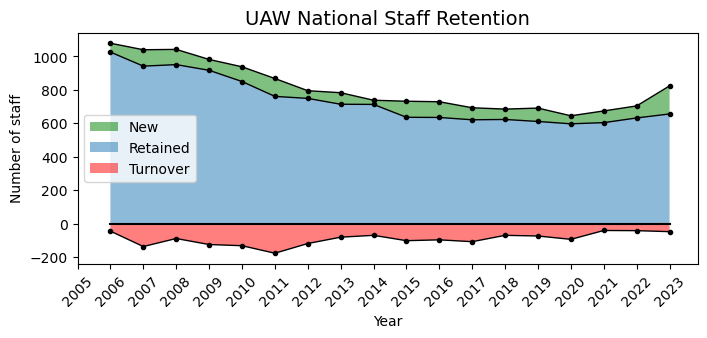

In [192]:
plot_retentions(UAW_staff_retention, "UAW National Staff Retention")

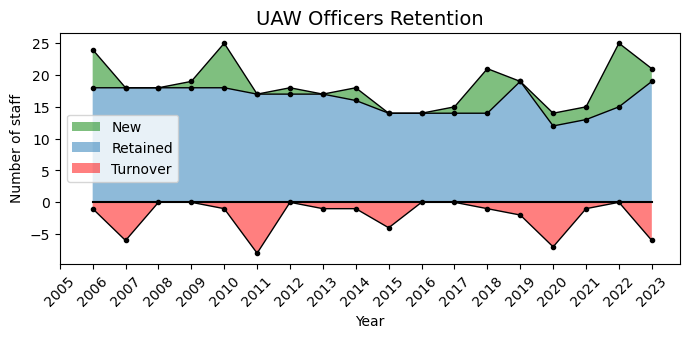

In [193]:
plot_retentions(UAW_officers_retention, "UAW Officers Retention")

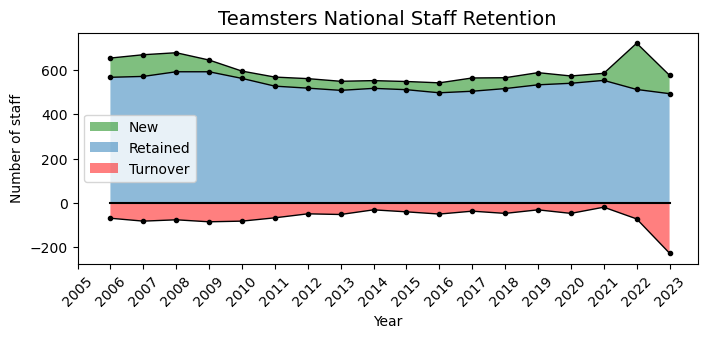

In [194]:
plot_retentions(Teamsters_staff_retention, "Teamsters National Staff Retention")

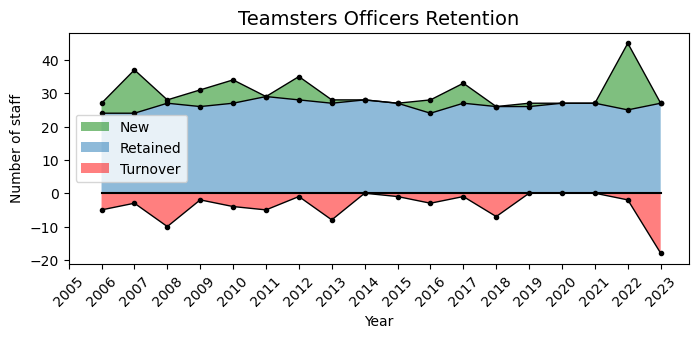

In [195]:
plot_retentions(Teamsters_officers_retention, "Teamsters Officers Retention")

# Analyzing individual staff and officer trajectories

In [202]:
def get_careers(df):
    df['Name'] = df['Name'].apply(lambda x: x.upper())
    names = df['Name'].unique()
    years = sorted(list(df['Year'].unique()))
    careers = {}
    for name in names:
        years_active = set(df[df['Name'] == name]['Year'])
        careers[name] = [1 if year in years_active else 0 for year in years]
    careers_df = pd.DataFrame.from_dict(careers, orient = 'columns')
    careers_df.index = years
    return careers_df

In [205]:
UAW_staff_careers = get_careers(UAW_staff)
UAW_officer_careers = get_careers(UAW_officers)
Teamsters_staff_careers = get_careers(Teamsters_staff)
Teamsters_officer_careers = get_careers(Teamsters_officers)

In [282]:
def plot_careers(careers_df):
    names = careers_df.columns
    first_year_active = [careers_df[name].ne(0).idxmax() for name in names]
    first_year, last_year = [careers_df.index.min(), careers_df.index.max()]
    low_end = 0.25
    high_end = 0.75
    colors = list([tuple(low_end + (high_end-low_end)*((year-first_year)/(last_year-first_year)) for _ in range(3)) for year in first_year_active])
    fig, ax = plt.subplots(figsize = (10,3))
    plt.stackplot(careers_df.index, 
                  careers_df.transpose().values,
                 colors = colors,
                  step='pre'
                 )
    ax.set_xticks(range(first_year, last_year+1))
    ax.set_xticklabels(range(first_year, last_year+1), rotation = 45)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number employed")

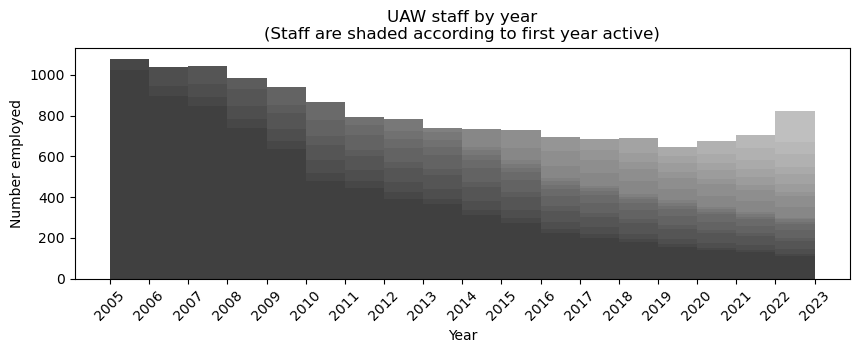

In [283]:
plot_careers(UAW_staff_careers)
plt.title("UAW staff by year\n(Staff are shaded according to first year active)")
plt.show()

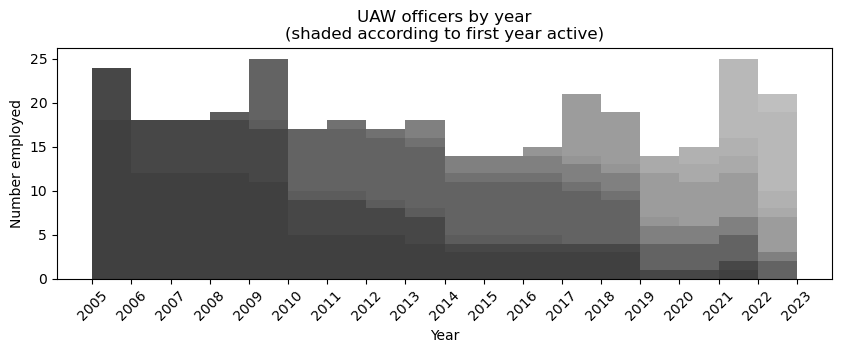

In [284]:
plot_careers(UAW_officer_careers)
plt.title("UAW officers by year\n(shaded according to first year active)")
plt.show()

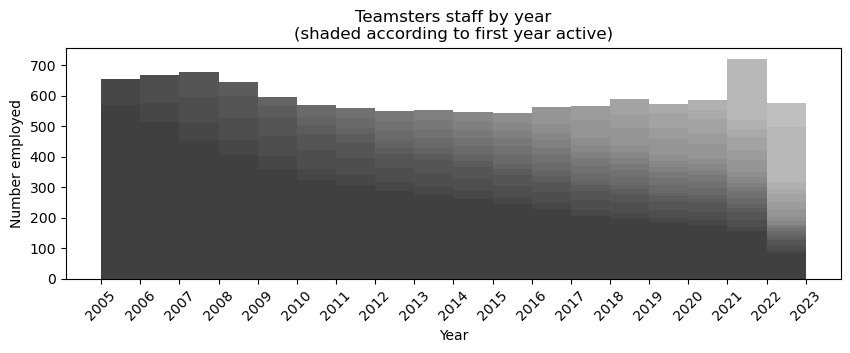

In [285]:
plot_careers(Teamsters_staff_careers)
plt.title("Teamsters staff by year\n(shaded according to first year active)")
plt.show()

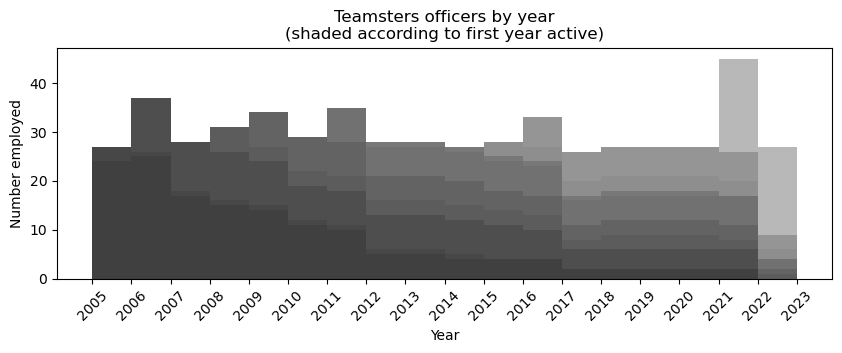

In [286]:
plot_careers(Teamsters_officer_careers)
plt.title("Teamsters officers by year\n(shaded according to first year active)")
plt.show()